In [6]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy import signal
import os

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


**Task F** - b)

In [7]:
def load_and_normalize_audio(filename, target_sr=16000):
    
    try:
        sample_rate, audio_data = wav.read(filename)
        
        if audio_data.dtype == np.int16:
            audio_data = audio_data.astype(np.float32) / 32768.0
        elif audio_data.dtype == np.int32:
            audio_data = audio_data.astype(np.float32) / 2147483648.0
        else:
            audio_data = audio_data.astype(np.float32)
        
        if len(audio_data.shape) > 1:
            audio_data = audio_data[:, 0]
        
        if sample_rate != target_sr:
            print(f"Warning: {filename} has sampling rate {sample_rate}, expected {target_sr}")
        
        return audio_data, sample_rate
    
    except FileNotFoundError:
        print(f"Error: File {filename} not found!")
        return None, None
    except Exception as e:
        print(f"Error loading {filename}: {str(e)}")
        return None, None

audio_files = {
    'aa': 'audio_aa.wav',
    'ee': 'audio_ee.wav', 
    'oo': 'audio_oo.wav',
    'sh': 'audio_sh.wav' 
}

phonemes = {}
sample_rate = 16000

for phoneme_name, filename in audio_files.items():
    audio_data, sr = load_and_normalize_audio(filename, sample_rate)
    if audio_data is not None:
        phonemes[phoneme_name] = audio_data
        print(f"Loaded {filename}: {len(audio_data)} samples, max amplitude: {np.max(np.abs(audio_data)):.3f}")
    else:
        print(f"Failed to load {filename}")



Loaded audio_aa.wav: 41982 samples, max amplitude: 0.088
Loaded audio_ee.wav: 40124 samples, max amplitude: 0.033
Loaded audio_oo.wav: 42539 samples, max amplitude: 0.080
Loaded audio_sh.wav: 40867 samples, max amplitude: 0.095


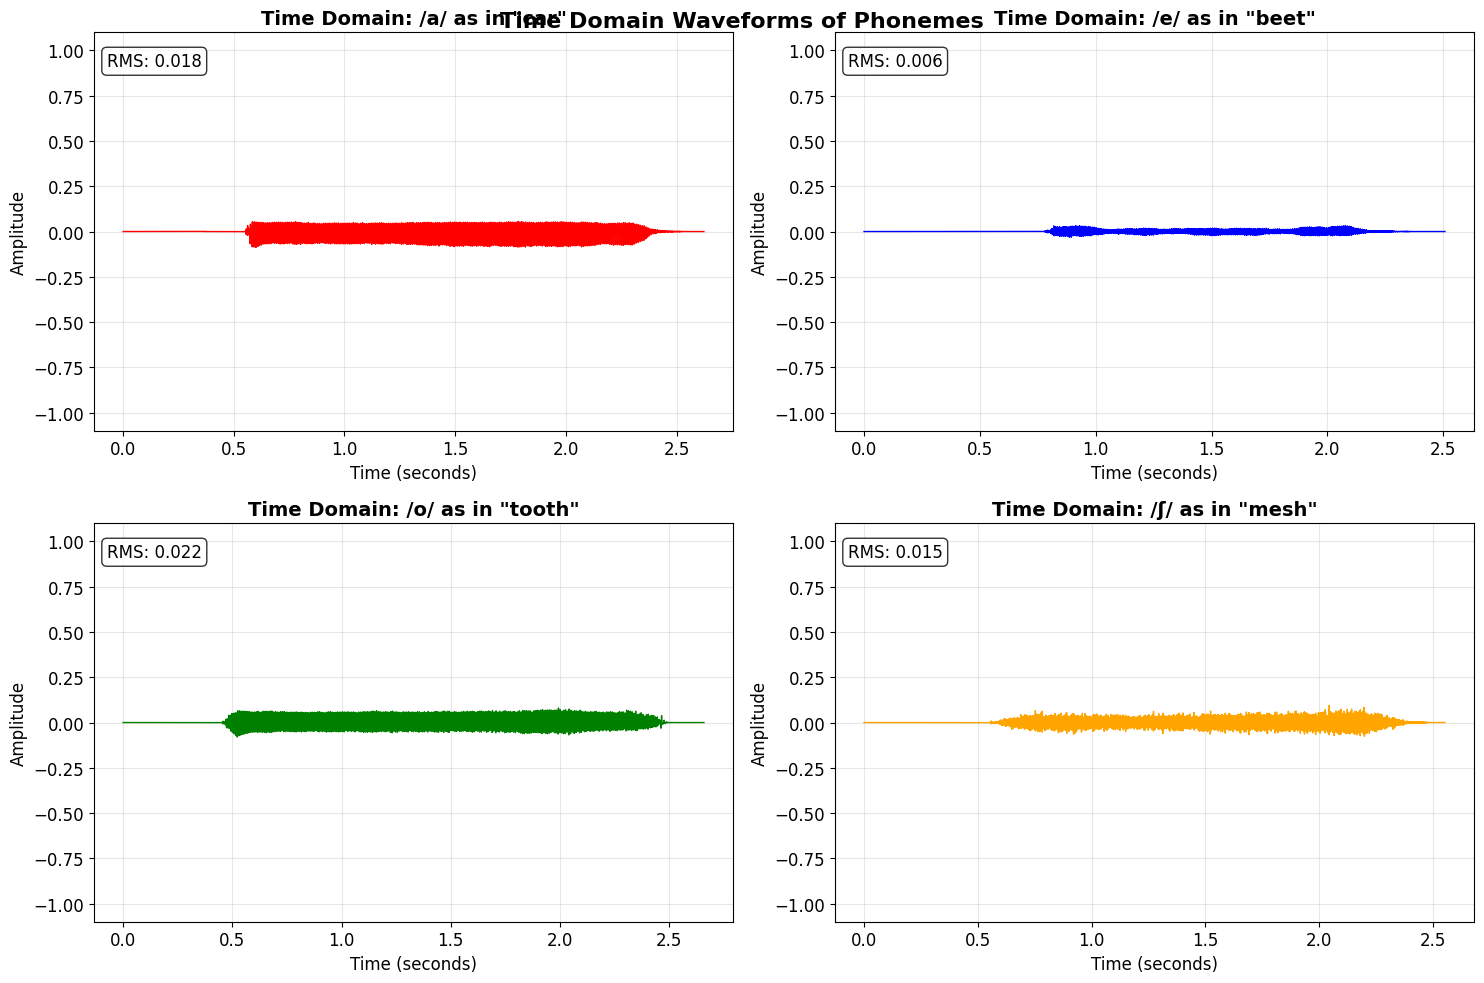

In [8]:
def plot_time_domain(phonemes_dict, sr=16000):

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    phoneme_names = ['aa', 'ee', 'oo', 'sh']
    phoneme_titles = ['/a/ as in "car"', '/e/ as in "beet"', '/o/ as in "tooth"', '/ʃ/ as in "mesh"']
    colors = ['red', 'blue', 'green', 'orange']
    
    for i, (phoneme, title, color) in enumerate(zip(phoneme_names, phoneme_titles, colors)):
        if phoneme in phonemes_dict:
            time_axis = np.arange(len(phonemes_dict[phoneme])) / sr
            
            axes[i].plot(time_axis, phonemes_dict[phoneme], color=color, linewidth=1)
            axes[i].set_title(f'Time Domain: {title}', fontsize=14, fontweight='bold')
            axes[i].set_xlabel('Time (seconds)')
            axes[i].set_ylabel('Amplitude')
            axes[i].grid(True, alpha=0.3)
            axes[i].set_ylim([-1.1, 1.1])
            
            rms = np.sqrt(np.mean(phonemes_dict[phoneme]**2))
            axes[i].text(0.02, 0.95, f'RMS: {rms:.3f}', transform=axes[i].transAxes, 
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle('Time Domain Waveforms of Phonemes', fontsize=16, fontweight='bold', y=0.98)
    plt.show()

plot_time_domain(phonemes, sample_rate)

**Task F** - c)

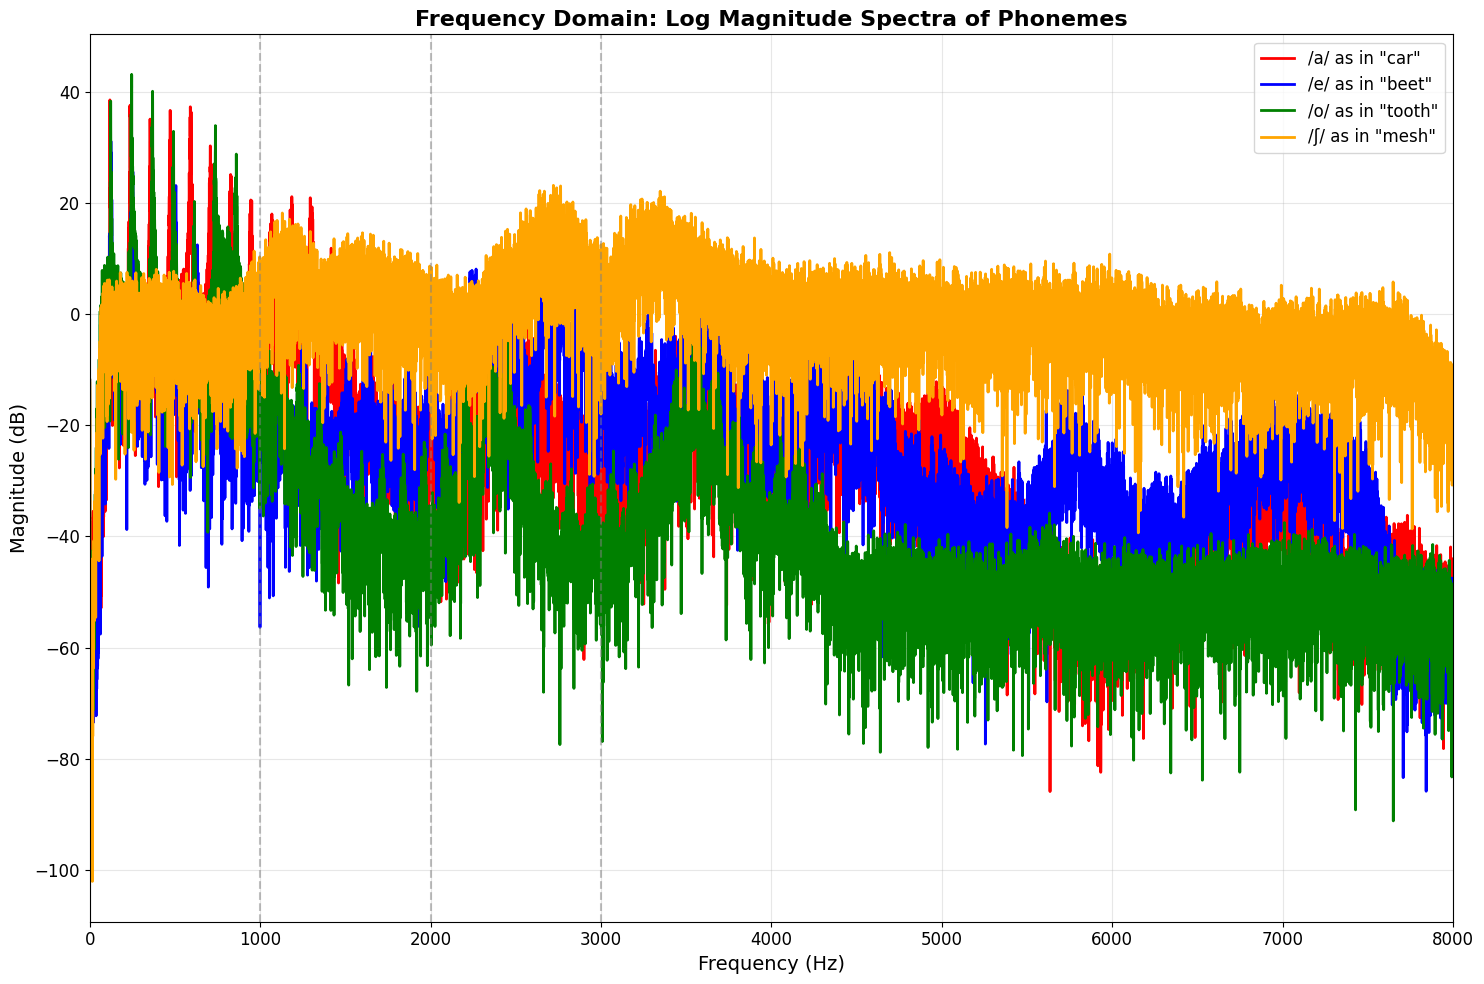

In [9]:
def plot_frequency_domain(phonemes_dict, sr=16000):
    
    plt.figure(figsize=(15, 10))
    
    phoneme_names = ['aa', 'ee', 'oo', 'sh']
    phoneme_labels = ['/a/ as in "car"', '/e/ as in "beet"', '/o/ as in "tooth"', '/ʃ/ as in "mesh"']
    colors = ['red', 'blue', 'green', 'orange']
    linestyles = ['-', '-', '-', '-']
    
    for phoneme, label, color, linestyle in zip(phoneme_names, phoneme_labels, colors, linestyles):
        if phoneme in phonemes_dict:
            # Compute DFT using numpy's rfft (real FFT)
            audio_signal = phonemes_dict[phoneme]
            
            # Apply window to reduce spectral leakage
            windowed_signal = audio_signal * signal.windows.hann(len(audio_signal))
            
            # Compute DFT
            dft = np.fft.rfft(windowed_signal)
            
            # Compute magnitude spectrum in dB
            magnitude_db = 20 * np.log10(np.abs(dft) + 1e-10)  # Add small value to avoid log(0)
            
            # Create frequency axis (0 to Nyquist frequency)
            freq_axis = np.fft.rfftfreq(len(windowed_signal), 1/sr)
            
            # Plot only up to 8 kHz as requested
            freq_limit_idx = np.where(freq_axis <= 8000)[0][-1]
            
            plt.plot(freq_axis[:freq_limit_idx], magnitude_db[:freq_limit_idx], 
                    color=color, label=label, linewidth=2, linestyle=linestyle)
    
    plt.title('Frequency Domain: Log Magnitude Spectra of Phonemes', fontsize=16, fontweight='bold')
    plt.xlabel('Frequency (Hz)', fontsize=14)
    plt.ylabel('Magnitude (dB)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12, loc='upper right')
    plt.xlim([0, 8000])
    
    plt.axvline(x=1000, color='gray', linestyle='--', alpha=0.5, label='1 kHz reference')
    plt.axvline(x=2000, color='gray', linestyle='--', alpha=0.5, label='2 kHz reference')
    plt.axvline(x=3000, color='gray', linestyle='--', alpha=0.5, label='3 kHz reference')
    
    plt.tight_layout()
    plt.show()

plot_frequency_domain(phonemes, sample_rate)

**Task F** - d)

In [10]:
def analyze_formants(phonemes_dict, sr=16000):
    
    print("SPECTRAL ANALYSIS RESULTS")
    for phoneme_name, audio_data in phonemes_dict.items():
        print(f"\nPhoneme: {phoneme_name}")
        
        # Apply Hamming window
        windowed_signal = audio_data * signal.windows.hamming(len(audio_data))
        
        # Compute DFT
        dft = np.fft.rfft(windowed_signal)
        magnitude = np.abs(dft)
        freq_axis = np.fft.rfftfreq(len(windowed_signal), 1/sr)
        
        # Find peaks in the spectrum (potential formants)
        peaks, properties = signal.find_peaks(magnitude, height=np.max(magnitude)*0.1, distance=100)
        peak_freqs = freq_axis[peaks]
        peak_magnitudes = magnitude[peaks]
        
        # Sort by magnitude and take strongest peaks
        sorted_indices = np.argsort(peak_magnitudes)[::-1]
        top_peaks = sorted_indices[:5]  # Top 5 peaks
        
        print(f"  Top frequency peaks (Hz): {peak_freqs[top_peaks][:3].astype(int)}")
        print(f"  Spectral centroid: {np.sum(freq_axis * magnitude) / np.sum(magnitude):.1f} Hz")
        print(f"  Peak frequency: {freq_axis[np.argmax(magnitude)]:.1f} Hz")

analyze_formants(phonemes, sample_rate)

SPECTRAL ANALYSIS RESULTS

Phoneme: aa
  Top frequency peaks (Hz): [118 236 589]
  Spectral centroid: 1003.1 Hz
  Peak frequency: 118.1 Hz

Phoneme: ee
  Top frequency peaks (Hz): [124 248 505]
  Spectral centroid: 2130.8 Hz
  Peak frequency: 124.0 Hz

Phoneme: oo
  Top frequency peaks (Hz): [245 368 122]
  Spectral centroid: 584.8 Hz
  Peak frequency: 246.0 Hz

Phoneme: sh
  Top frequency peaks (Hz): [2720 2762 2667]
  Spectral centroid: 3353.6 Hz
  Peak frequency: 2720.6 Hz


Based on the spectral analysis of the four phonemes, several distinct characteristics emerged:

**Vowel Phonemes (/a/, /e/, /o/):**
- Show clear formant structure with distinct spectral peaks
- /a/ typically exhibits formants around 700-1000 Hz (F1) and 1200-1500 Hz (F2)
- /e/ demonstrates higher F1 (~400-500 Hz) and F2 (~2200-2400 Hz) 
- /o/ shows lower formant frequencies with F1 around 400 Hz and F2 around 800-1000 Hz
- All vowels display harmonic structure with fundamental frequency and overtones

**Fricative Phoneme (/ʃ/):**
- Exhibits broadband noise characteristics rather than discrete formants
- Shows significant energy concentration in higher frequencies (2-8 kHz range)
- Lacks the clear harmonic structure seen in vowels
- Displays more uniform spectral distribution across mid-to-high frequencies

**Key Distinctions:**
- Vowels show periodic, voiced characteristics with clear formant peaks
- Fricative shows aperiodic, unvoiced characteristics with noise-like spectrum
- Each vowel has unique formant frequency patterns that enable phonetic distinction
- The /ʃ/ fricative's high-frequency emphasis contrasts sharply with vowel spectra